In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# ── Load CSV ──────────────────────────────────────────────────────────────────
def load_scan(csv_path: str) -> pd.DataFrame:
    """Load the scan CSV and add derived columns."""
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")
    
    df = pd.read_csv(csv_path)
    
    # Drop rows where file was not found
    n_missing = (df["file_found"] == 0).sum()
    if n_missing > 0:
        print(f"  WARNING: {n_missing} rows had file_found=0 and will be dropped.")
        #print out the parameters of the missing rows for debugging
        missing_rows = df[df["file_found"] == 0]
        print("  Missing rows parameters:")
        print(missing_rows[["tel_x", "tel_z", "zen", "az", "height"]])
    df = df[df["file_found"] == 1].copy()
    
    # Derived columns
    df["r"] = np.sqrt(df["tel_x"]**2 + df["tel_z"]**2).round(4)
    df["detected"] = (df["max_pe"] >= PE_THRESHOLD).astype(float)
    
    #print(f"Loaded {len(df)} valid rows from '{csv_path}'")
    #print(f"Columns: {list(df.columns)}")
    #print(df.describe())
    return df
def slant_depth(zem, obs_height, zenith_rad):
        theta = np.pi - zenith_rad
        beta = np.clip(np.arcsin((obs_height / zem) * np.sin(theta)), 0, np.pi/2)
        alpha = np.pi - theta - beta
        s = zem * np.sin(alpha) / np.sin(theta)
        return np.clip(s, 0, np.inf)


  Missing rows parameters:
       tel_x  tel_z   zen   az  height
6010     5.0    0.7  89.9  269    5000
6011     5.0    1.0  89.9  269    5000
6179     5.0    0.7  89.9  269   10000
6180     5.0    1.0  89.9  269   10000
6348     5.0    0.7  89.9  269   15000
...      ...    ...   ...  ...     ...
14308   -0.7   -0.7  89.9  270   30000
14309   -0.7   -0.5  89.9  270   30000
14312   -0.7    0.2  89.9  270   30000
14313   -0.7    0.5  89.9  270   30000
14314   -0.7    0.7  89.9  270   30000

[289 rows x 5 columns]
  Loaded seed 1: 16611 rows
  Missing rows parameters:
       tel_x  tel_z   zen   az  height
0       -5.0   -5.0  89.9  268    5000
14      -2.0   -2.0  89.9  268    5000
28      -1.0   -1.0  89.9  268    5000
42      -0.7   -0.7  89.9  268    5000
56      -0.5   -0.5  89.9  268    5000
...      ...    ...   ...  ...     ...
14308   -0.7   -0.7  89.9  270   30000
14309   -0.7   -0.5  89.9  270   30000
14312   -0.7    0.2  89.9  270   30000
14313   -0.7    0.5  89.9  270   300

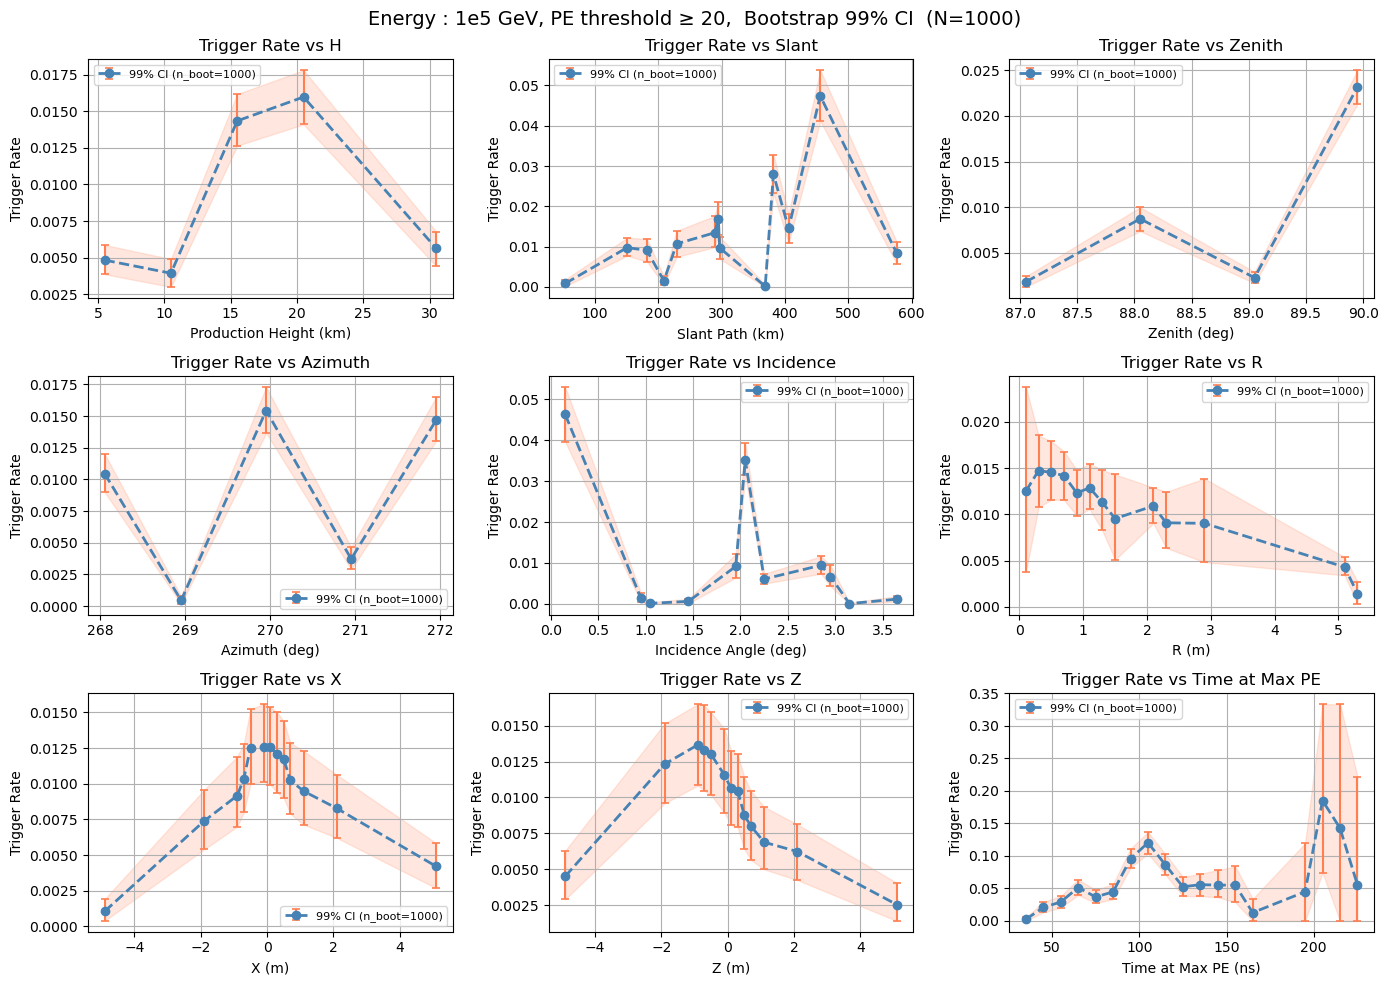

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── Configuration ─────────────────────────────────────────────────────────────
PE_THRESHOLD = 20
N_BOOTSTRAP = 1000
CI_LEVEL = 0.99
E_mag = 5
SEEDS = [1,2,3,4,5,6,7,8]  # List of seeds to merge

# ── Merge all seeds ──────────────────────────────────────────────────────────
dfs = []
for seed in SEEDS:
    csv_path = f"/scratch/general/vast/u1520754/muon_sim_chain/Muon_pid13_E1e{E_mag}_R5/csv_output/scan_care_pid13_E1e{E_mag}_R5_y0_s{seed}.csv"
    try:
        df_tmp = load_scan(csv_path)
        df_tmp["seed"] = seed
        dfs.append(df_tmp)
        print(f"  Loaded seed {seed}: {len(df_tmp)} rows")
    except Exception as e:
        print(f"  ⚠ Seed {seed} failed: {e}")

df = pd.concat(dfs, ignore_index=True)
print(f"\nMerged: {len(df)} total rows from {len(dfs)} seeds")

# ── Derived columns ──────────────────────────────────────────────────────────
R = np.array(df["r"])
X = np.array(df["tel_x"])
Z = np.array(df["tel_z"])
H = np.array(df["height"])
Zenith = np.array(df["zen"])
Azimuth = np.array(df["az"])
Max_PE = np.array(df["max_pe"])
Time_at_Max_PE = np.array(df["time_at_max_pe_ns"])
Avg_PE = np.array(df["avg_pe"])
Total_PE = np.array(df["total_pe"])
Slant = slant_depth(H + 6371e3, 2944 + 6371e3, np.radians(Zenith))
cos_Zenith = np.cos(np.radians(Zenith))
cos_Azimuth = np.cos(np.radians(Azimuth - 180))
cos_Incidence = np.sqrt(1 - cos_Zenith**2 - cos_Azimuth**2)
Incidence = np.degrees(np.arccos(cos_Incidence))

variables = {
    "H": (H / 1000, "Production Height (km)", 1),
    "Slant": (Slant / 1000, "Slant Path (km)", 1),
    "Zenith": (Zenith, "Zenith (deg)", 0.1),
    "Azimuth": (Azimuth, "Azimuth (deg)", 0.1),
    "Incidence": (Incidence, "Incidence Angle (deg)", 0.1),
    "R": (R, "R (m)", 0.2),
    "X": (X, "X (m)", 0.2),
    "Z": (Z, "Z (m)", 0.2),
    "Time at Max PE": (Time_at_Max_PE, "Time at Max PE (ns)", 10),
}

PE_threshold = PE_THRESHOLD
alpha = 1.0 - CI_LEVEL  # 0.01 for 99% CI
lo_pct = 100 * alpha / 2        # 0.5
hi_pct = 100 * (1 - alpha / 2)  # 99.5


def bootstrap_trigger_rate(max_pe_in_bin, threshold, n_boot=N_BOOTSTRAP):
    """Return (rate, ci_low, ci_high) via bootstrap resampling."""
    n = len(max_pe_in_bin)
    if n == 0:
        return np.nan, np.nan, np.nan
    observed_rate = np.sum(max_pe_in_bin >= threshold) / n
    boot_rates = np.empty(n_boot)
    for b in range(n_boot):
        sample = np.random.choice(max_pe_in_bin, size=n, replace=True)
        boot_rates[b] = np.sum(sample >= threshold) / n
    ci_low = np.percentile(boot_rates, lo_pct)
    ci_high = np.percentile(boot_rates, hi_pct)
    return observed_rate, ci_low, ci_high


fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, (var, xlabel, bin_size)) in zip(axes, variables.items()):
    var = np.array(var)
    mask = ~np.isnan(var)
    var = var[mask]
    max_pe_filtered = Max_PE[mask]

    if len(var) == 0:
        ax.set_title(f"{name} — no data")
        continue

    var_bins = np.arange(min(var)-bin_size, max(var) + 2*bin_size, bin_size)
    trigger_rates = []
    ci_lows = []
    ci_highs = []
    bin_centers = []

    for i in range(len(var_bins) - 1):
        bin_mask = (var >= var_bins[i]) & (var < var_bins[i + 1])
        max_PE_in_bin = max_pe_filtered[bin_mask]
        if len(max_PE_in_bin) <= 1:  # Need at least 2 samples for bootstrap
            continue

        rate, ci_lo, ci_hi = bootstrap_trigger_rate(max_PE_in_bin, PE_threshold)
        if rate == 0:
            continue  # Skip bins with zero trigger rate to avoid clutter
        trigger_rates.append(rate)
        ci_lows.append(ci_lo)
        ci_highs.append(ci_hi)
        bin_centers.append(var_bins[i] + bin_size / 2)

    bin_centers = np.array(bin_centers)
    trigger_rates = np.array(trigger_rates)
    ci_lows = np.array(ci_lows)
    ci_highs = np.array(ci_highs)

    # Error bars: distance from point to CI bounds
    yerr_lo = trigger_rates - ci_lows
    yerr_hi = ci_highs - trigger_rates
    ax.errorbar(
        bin_centers, trigger_rates,
        yerr=[yerr_lo, yerr_hi],
        fmt="--o", color="steelblue", ecolor="coral",
        elinewidth=1.5, capsize=3, capthick=1.2, linewidth=2,
        label=f"99% CI (n_boot={N_BOOTSTRAP})",
    )
    ax.fill_between(bin_centers, ci_lows, ci_highs, alpha=0.18, color="coral")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Trigger Rate")
    ax.set_title(f"Trigger Rate vs {name}")
    ax.legend(fontsize=8)
    ax.grid(True)

plt.suptitle(f"Energy : 1e{E_mag} GeV, PE threshold ≥ {PE_THRESHOLD},  Bootstrap 99% CI  (N={N_BOOTSTRAP})", fontsize=14)
plt.tight_layout()
plt.show()


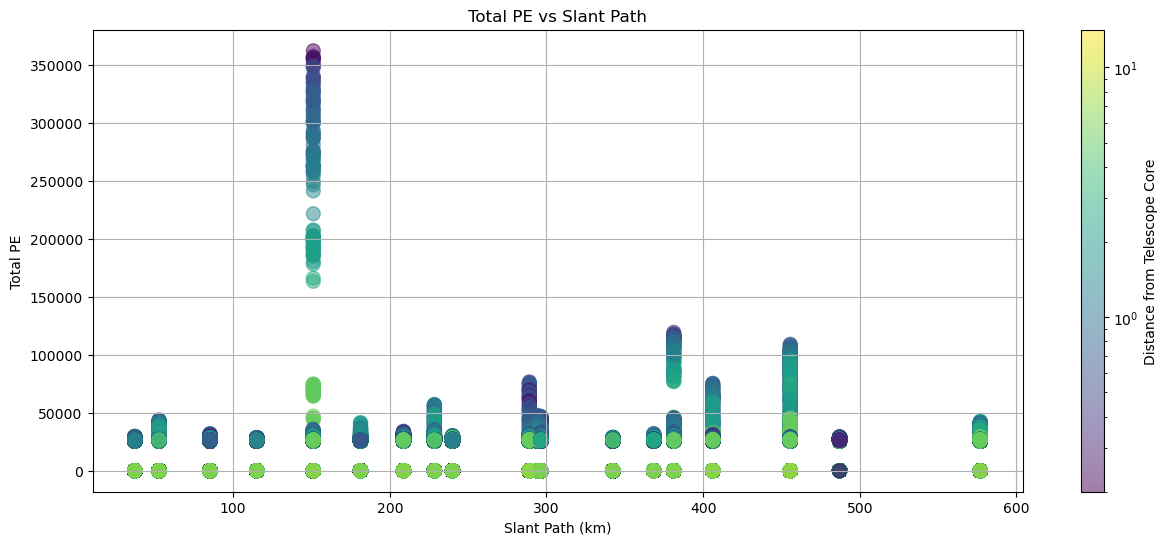

In [ ]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 6))
size = 100
plt.scatter(Slant/1000, Total_PE, c=R, cmap="viridis", s=size, alpha=0.5, norm=LogNorm())
plt.colorbar(label="Distance from Telescope Core")
plt.xlabel("Slant Path (km)")
plt.ylabel("Total PE")
plt.title("Total PE vs Slant Path")
#plt.yscale("log")
plt.grid(True)
plt.show()